In [1]:
from griddify import datasets

data = datasets.get_compound_descriptors()

In [4]:
from griddify.utils import Mixed_KSG
import numpy as np
from tqdm import tqdm

class FeatureMutualInformation(object):
    def __init__(self, max_n=10000):
        self.max_n = max_n

    def calculate(self, data):
        X = np.array(data)[:self.max_n]
        M = np.zeros((X.shape[1], X.shape[1]))
        for i in range(X.shape[1]):
            for j in range(i, X.shape[1]):
                x = X[:,i]
                y = X[:,j]
                mi = Mixed_KSG(x,y,k=5)
                M[i,j]=mi
                M[j,j]=mi
        return M

fm = FeatureMutualInformation()

In [5]:
fm.calculate(data)

In [16]:
from griddify import datasets
from griddify import Griddify

data = datasets.get_compound_descriptors()

gf = Griddify(preprocess=True, max_side=128)
gf.fit(data)
Xi = gf.transform(data)

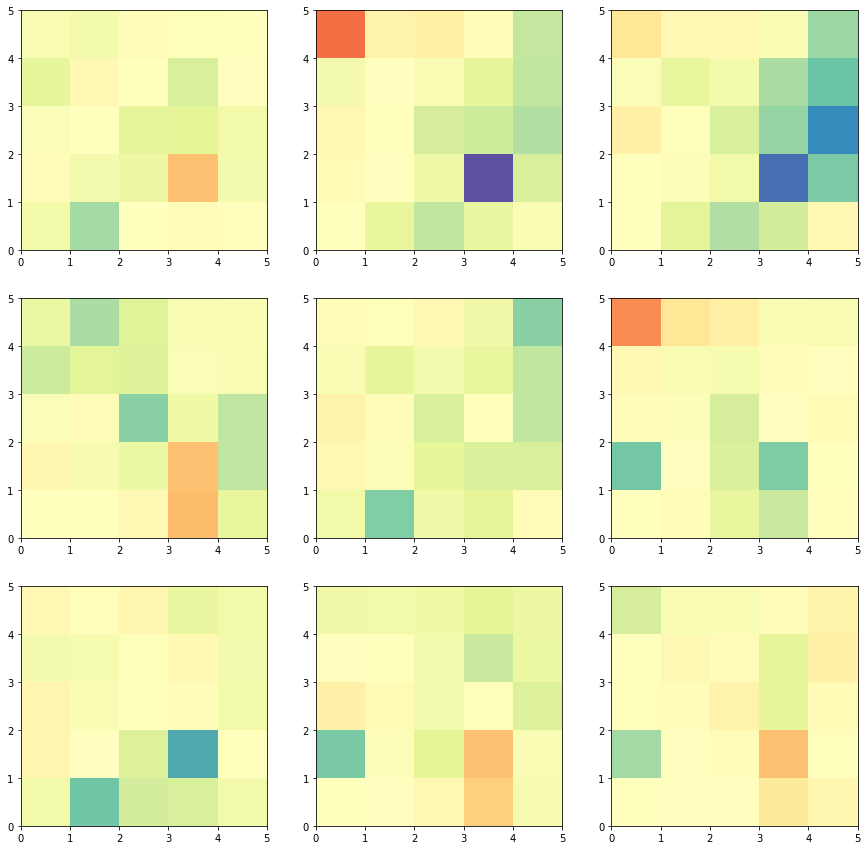

In [15]:
from griddify.plots import grid_plot

fig, axs = plt.subplots(3,3, figsize=(15,15))
axs = axs.flatten()

for i in range(9):
    ax = axs[i]
    grid_plot(Xi[i], ax=ax, s=50)

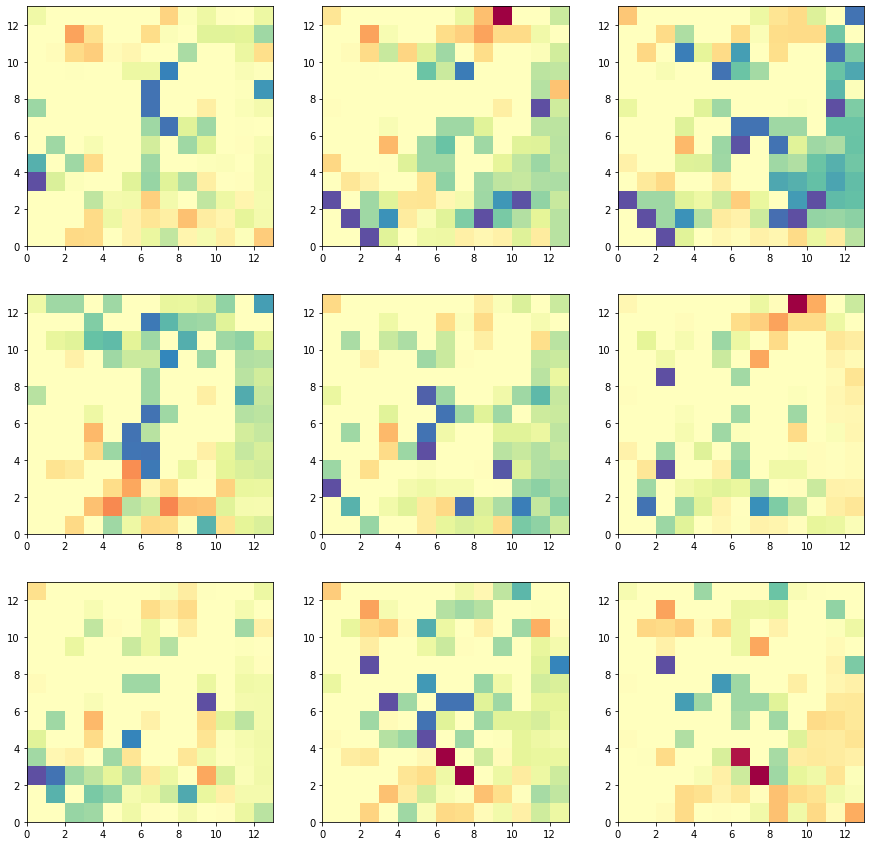

In [17]:
from griddify.plots import grid_plot

fig, axs = plt.subplots(3,3, figsize=(15,15))
axs = axs.flatten()

for i in range(9):
    ax = axs[i]
    grid_plot(Xi[i], ax=ax, s=50)

In [3]:
from griddify import Preprocessing

pp  = Preprocessing()
pp.fit(data)
data = pp.transform(data)

In [4]:
from griddify import FeatureDistances

fd = FeatureDistances(metric="cosine").calculate(data)

In [5]:
from griddify import Tabular2Cloud

tc = Tabular2Cloud()
tc.fit(fd)
Xc = tc.transform(fd)

In [6]:
from griddify.plots import cloud_plot

<AxesSubplot:>

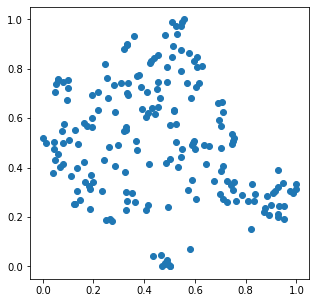

In [7]:
cloud_plot(Xc)

In [9]:
from griddify import Cloud2Grid

cg = Cloud2Grid(max_side=128)
cg.fit(Xc)
Xg = cg.transform(Xc, as_integers=False)

<AxesSubplot:>

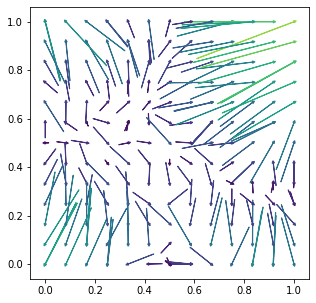

In [10]:
from griddify.plots import arrows_plot

arrows_plot(Xc, Xg, capping_distance=0.5)

In [11]:
from griddify import Cloud2Grid

cg = Cloud2Grid(max_side=128)
cg.fit(Xc)
mappings, side = cg.get_mappings(Xc)

In [12]:
from griddify import Flat2Grid

tg = Flat2Grid(mappings, side)
Xi = tg.transform(data)

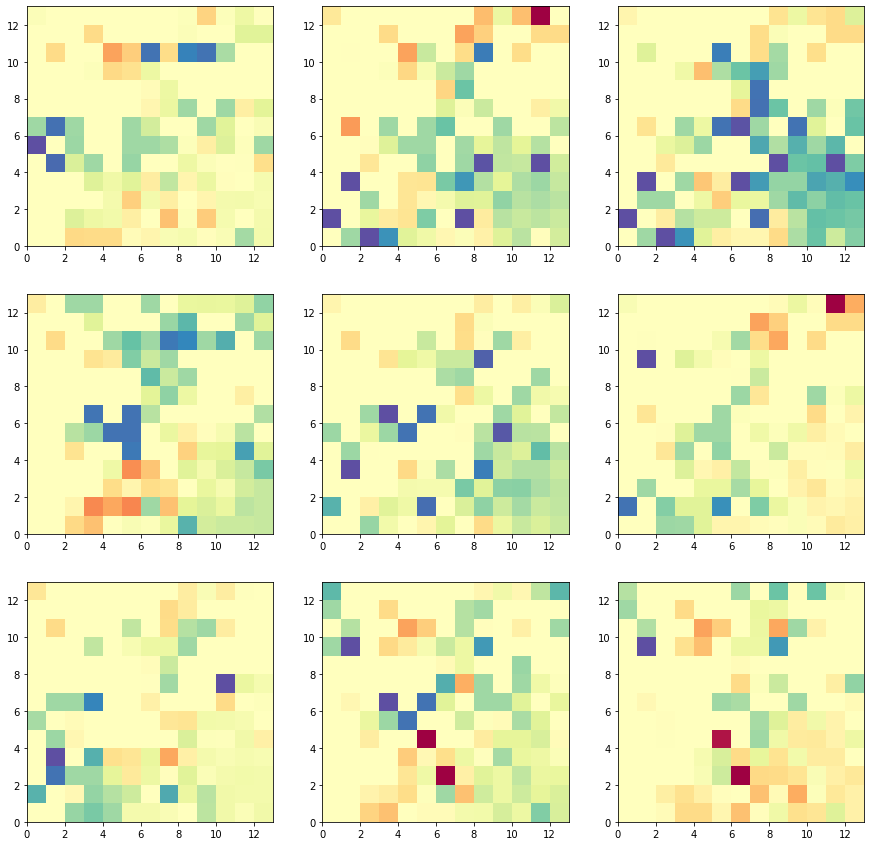

In [13]:
fig, axs = plt.subplots(3,3, figsize=(15,15))
axs = axs.flatten()

for i in range(9):
    ax = axs[i]
    grid_plot(Xi[i], ax=ax, s=50)

In [2]:
import numpy as np

np.sqrt(3200)

56.568542494923804

In [30]:
import scipy.spatial as ss
from scipy.special import digamma
from math import log
import numpy as np


def Mixed_KSG(x,y,k=5):
    assert len(x)==len(y), "Lists should have same length"
    assert k <= len(x)-1, "Set k smaller than num. samples - 1"
    N = len(x)
    if x.ndim == 1:
        x = x.reshape((N,1))
    dx = len(x[0])   	
    if y.ndim == 1:
        y = y.reshape((N,1))
    dy = len(y[0])
    data = np.concatenate((x,y),axis=1)

    tree_xy = ss.cKDTree(data)
    tree_x = ss.cKDTree(x)
    tree_y = ss.cKDTree(y)

    knn_dis = [tree_xy.query(point,k+1,p=float('inf'))[0][k] for point in data]
    ans = 0

    for i in range(N):
        kp, nx, ny = k, k, k
        if knn_dis[i] == 0:
            kp = len(tree_xy.query_ball_point(data[i],1e-15,p=float('inf')))
            nx = len(tree_x.query_ball_point(x[i],1e-15,p=float('inf')))
            ny = len(tree_y.query_ball_point(y[i],1e-15,p=float('inf')))
        else:
            nx = len(tree_x.query_ball_point(x[i],knn_dis[i]-1e-15,p=float('inf')))
            ny = len(tree_y.query_ball_point(y[i],knn_dis[i]-1e-15,p=float('inf')))
        ans += (digamma(kp) + log(N) - digamma(nx) - digamma(ny))/N
    return ans

Mixed_KSG(np.array([1,2,3,4,5,6,7,8]), np.array([1,2,3,4,5,6,7,8]))
Mixed_KSG(np.array([8,8,8,8,8,8,8,8]), np.array([1,2,3,4,5,6,7,8]))

0.06380006372422597